# Bayesian Inference for Interleaved Randomized Benchmarking


## Introduction

This notebook gives an example of how to use Bayesian inference as a help for randomized benchmarking. The Pymc3 and Arviz python packages are used for this purpose. Priors are obtained from the fitter included in the Qiskit ``ignis.verification.randomized_benchmarking``module. A pooled and a hierarchical model are tested and compared. The model's parameters are ajusted and the error per Clifford (EPC) is estimated, together with a credible interval. For reference, an EPC value is calculated from the noisy model of the simulation.

Thes notebook is based on the examples of the ignis noise tutorial on randomized benchmarking.

In [1]:
#Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

#Import Qiskit classes
import qiskit
from qiskit.tools.monitor import job_monitor
from qiskit import Aer
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

#Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb

import copy
import time

# import the bayesian packages
import pymc3 as pm
import arviz as az

In [2]:
# initialize the Bayesian extension
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
# This section for the LS fit in this model pooling
# data from 2Q and 3Q interleave processes

from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * b ** x + c
def epc_fitter_when_mixed_2Q_3Q_RB(xdata,Y1,Y2,shots,check_plot=False):
    
    ydata1 = np.mean(Y1,axis=0)/shots 
    
    popt, pcov = curve_fit(func, xdata, ydata1)
    perr= np.sqrt(np.diag(pcov))
    ydata2 = np.mean(Y2,axis=0)/shots
    popt2, pcov2 = curve_fit(func, xdata, ydata2)
    perr2= np.sqrt(np.diag(pcov2))
    
    if check_plot:
        import matplotlib.pyplot as plt
        plt.plot(xdata, ydata1, 'b-', label='Reference')
        plt.plot(xdata, ydata2, 'r-', label='Interleave')
        plt.ylabel('Population of |00>')
        plt.xlabel('Number of Cliffords')
        plt.legend()
        plt.show()

    epc_est_fitter = 3*(1 - popt2[1]/popt[1])/4
    epc_est_fitter_err = 3*(popt2[1]/popt[1])/4 * (np.sqrt(perr[1]**2 + perr2[1]**2))
    return epc_est_fitter, epc_est_fitter_err

In [4]:
def obtain_priors_and_data_from_fitter(rbfit,printout = True):
    
    
    m_gates = copy.deepcopy(nCliffs)
    # We choose the count matrix corresponding to 2 Qubit RB
    Y = (np.array(rbfit._raw_data[0])*shots).astype(int)
    
    # alpha prior and bounds 
    alpha_ref = rbfit._fit[0]['params'][1]    
    #alpha_lower = alpha_ref - 6*rbfit._fit[0]['params_err'][1] 
    #alpha_upper = alpha_ref + 6*rbfit._fit[0]['params_err'][1] 
    alpha_lower = .95*alpha_ref 
    alpha_upper = min(1.05*alpha_ref,1.0) 
    # priors for A anbd B
    mu_AB = np.delete(rbfit._fit[0]['params'],1)
    cov_AB=np.delete(rbfit._fit[0]['params_err'],1)**2
    
    # prior for sigma theta:
    sigma_theta = 0.004 # WIP   
    if printout:
        print("priors:\nalpha_ref",alpha_ref)
        print("alpha_lower", alpha_lower, "alpha_upper", alpha_upper)
        print("A,B", mu_AB, "\ncov A,B", cov_AB)
        print("sigma_theta", sigma_theta)
    
    return m_gates, Y, alpha_ref, alpha_lower, alpha_upper, mu_AB, cov_AB, sigma_theta

In [5]:
# modified for accelerated BM with EPCest as extra parameter
def get_bayesian_model(model_type,Y,shots,m_gates,mu_AB,cov_AB,
                            alpha_lower=0.5,alpha_upper=0.999,alpha_testval=0.9,                            
                            p_lower=0.9,p_upper=0.999,p_testval=0.95,
                            RvsI=None,IvsR=None,sigma_theta=0.004): 
# Bayesian model
# from https://iopscience.iop.org/arti=RvsI, cle/10.1088/1367-2630/17/1/013042/pdf 
# see https://docs.pymc.io/api/model.html
    
    RB_model = pm.Model()
    with RB_model:
        total_shots = np.full(Y.shape, shots)
       
        #Priors for unknown model parameters
        alpha = pm.Uniform("alpha",lower=alpha_lower,
                           upper=alpha_upper, testval = alpha_ref)
        
        BoundedMvNormal = pm.Bound(pm.MvNormal, lower=0.0)
        
        AB = BoundedMvNormal("AB", mu=mu_AB,testval = mu_AB,
                         cov= np.diag(cov_AB),
                         shape = (2))
        
        if model_type == "hierarchical":
            GSP = AB[0]*alpha**m_gates + AB[1]
            theta = pm.Beta("GSP",
                             mu=GSP,
                             sigma = sigma_theta,
                             shape = Y.shape[1])
            # Likelihood (sampling distribution) of observations    
            p = pm.Binomial("Counts_h", p=theta, observed=Y,
                            n = total_shots) 
        
        elif model_type == "tilde":
            p_tilde = pm.Uniform("p_tilde",lower=p_lower,
                               upper=p_upper, testval = p_testval)
            GSP = AB[0]*(RvsI*alpha**m_gates + IvsR*(alpha*p_tilde)**m_gates) + AB[1]
            # Likelihood (sampling distribution) of observations    
            p = pm.Binomial("Counts_t", p=GSP, observed=Y,
                            n = total_shots) 
                       
        
        else:  # defaul model "pooled"      
            GSP = AB[0]*alpha**m_gates + AB[1]        
            # Likelihood (sampling distribution) of observations    
            p = pm.Binomial("Counts_p", p=GSP, observed=Y,
                            n = total_shots) 

    return RB_model

In [6]:
def get_bayesian_model_hierarchical(model_type,Y): # modified for accelerated BM with EPCest as extra parameter
# Bayesian model
# from https://iopscience.iop.org/article/10.1088/1367-2630/17/1/013042/pdf 
# see https://docs.pymc.io/api/model.html
    
    RBH_model = pm.Model()
    with RBH_model:
        
        #Priors for unknown model parameters
        alpha = pm.Uniform("alpha",lower=alpha_lower,
                           upper=alpha_upper, testval = alpha_ref)
        
        BoundedMvNormal = pm.Bound(pm.MvNormal, lower=0.0)
        
        AB = BoundedMvNormal("AB", mu=mu_AB,testval = mu_AB,
                         cov= np.diag(cov_AB),
                         shape = (2))

        # Expected value of outcome                
           
        GSP = AB[0]*alpha**m_gates + AB[1]
        
        
        total_shots = np.full(Y.shape, shots)
        theta = pm.Beta("GSP",
                     mu=GSP,
                     sigma = sigma_theta,
                     shape = Y.shape[1])
        
        # Likelihood (sampling distribution) of observations    
        p = pm.Binomial("Counts", p=theta, observed=Y,
                            n = total_shots) 

    return RBH_model

In [7]:
def get_trace(RB_model):
    # Gradient-based sampling methods
    # see also: https://docs.pymc.io/notebooks/sampler-stats.html
    # and https://docs.pymc.io/notebooks/api_quickstart.html
    with RB_model:   
        trace= pm.sample(draws = 2000, tune= 10000, target_accept=0.9, return_inferencedata=True)    

    with RB_model:
        az.plot_trace(trace);
        
    return trace

In [8]:
def get_summary(RB_model, trace, hdi_prob=.94, kind='all'):
    with RB_model:
        #  (hdi_prob=.94 is default)
        az_summary = az.summary(trace, round_to=4,  hdi_prob=hdi_prob, kind=kind )  
        
    return az_summary

In [9]:
# obtain EPC from alpha (used by plot_posterior)
def alpha_to_EPC(alpha):
        return 3*(1-alpha)/4   

In [10]:
def get_EPC_and_legends(rbfit,azs):
    EPC_Bayes = alpha_to_EPC(azs['mean']['alpha'])
    EPC_Bayes_err = EPC_Bayes - alpha_to_EPC(azs['mean']['alpha']+azs['sd']['alpha'])
    Bayes_legend ="EPC Bayes {0:.5f} ({1:.5f})".format(EPC_Bayes, EPC_Bayes_err)
    Fitter_legend ="EPC Fitter {0:.5f} ({1:.5f})".format(rbfit.fit[0]['epc']\
                                                        ,rbfit._fit[0]['epc_err'])
    if pred_epc > 0.0:
        pred_epc_legend = "EPC predicted {0:.5f}".format(pred_epc)
    else:
        pred_epc_legend = ''
    return EPC_Bayes, EPC_Bayes_err, Bayes_legend,Fitter_legend, pred_epc_legend
    
def EPC_compare_fitter_to_bayes(RB_model, azs, trace,m_name,rbfit):
    EPC_Bayes, EPC_Bayes_err, Bayes_legend,Fitter_legend, pred_epc_legend = get_EPC_and_legends(rbfit,azs)
    with RB_model:
        az.plot_posterior(trace,  var_names=['alpha'], round_to=4,
                          transform = alpha_to_EPC, point_estimate=None)
        plt.title("Error per Clifford  "+RB_process+"  device: "+hardware
                  +'  backend: '+backend.name()+'  model:'+m_name,
                  fontsize=12)
        plt.axvline(x=alpha_to_EPC(alpha_ref),color='red')
        if pred_epc > 0.0:
            plt.axvline(x=pred_epc,color='green') 
            plt.legend((Bayes_legend, "Higher density interval",Fitter_legend, pred_epc_legend), fontsize=10)
        else:
            plt.legend((Bayes_legend, "Higher density interval",Fitter_legend), fontsize=10 )
        
        plt.show()

In [11]:
def GSP_compare_fitter_to_bayes(RB_model, azs,m_name,rbfit):
    EPC_Bayes, EPC_Bayes_err, Bayes_legend,Fitter_legend,_ = get_EPC_and_legends(rbfit,azs)
    # plot ground state population ~ Clifford length
    fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10, 6))

    axes.set_ylabel("Ground State Population")
    axes.set_xlabel("Clifford Length")
    axes.plot(m_gates, np.mean(Y/shots,axis=0), 'r.')
    axes.plot(m_gates,azs['mean']['AB[0]']*azs['mean']['alpha']**m_gates+azs['mean']['AB[1]'],'--')
    #axes.plot(m_gates,azs['mean']['GSP'],'--') # WIP
    #axes.errorbar(m_gates, azs['mean']['GSP'], azs['sd']['GSP'], linestyle='None', marker='^') # WIP
    axes.plot(m_gates,mu_AB[0]*np.power(alpha_ref,m_gates)+mu_AB[1],':') 
    for i_seed in range(nseeds):
        plt.scatter(m_gates-0.25, Y[i_seed,:]/shots, label = "data", marker="x")
    axes.legend(["Mean Observed Frequencies",
                 "Bayesian Model\n"+Bayes_legend,
                 "Fitter Model\n"+Fitter_legend],fontsize=12)
    axes.set_title(RB_process+"  device: "+hardware+'  backend: '+backend.name()+'  model:'+m_name,
                   fontsize=14) # WIP
    

In [12]:
def get_predicted_EPC(error_source):

    #Count the number of single and 2Q gates in the 2Q Cliffords
    gates_per_cliff = rb.rb_utils.gates_per_clifford(transpile_list,xdata[0],basis_gates,rb_opts['rb_pattern'][0])
    for basis_gate in basis_gates:
        print("Number of %s gates per Clifford: %f "%(basis_gate ,
                                                      np.mean([gates_per_cliff[rb_pattern[0][0]][basis_gate],
                                                               gates_per_cliff[rb_pattern[0][1]][basis_gate]])))
    # Calculate the predicted epc
    # from the known depolarizing errors on the simulation
    if error_source == "depolarization":  
        # Error per gate from noise model
        epgs_1q = {'u1': 0, 'u2': p1Q/2, 'u3': 2*p1Q/2}
        epg_2q = p2Q*3/4
        pred_epc = rb.rb_utils.calculate_2q_epc(
            gate_per_cliff=gates_per_cliff,
            epg_2q=epg_2q,
            qubit_pair=[0, 2],
            list_epgs_1q=[epgs_1q, epgs_1q])

    # using the predicted primitive gate errors from the coherence limit
    if error_source == "from_T1_T2": 
        # Predicted primitive gate errors from the coherence limit
        u2_error = rb.rb_utils.coherence_limit(1,[t1],[t2],gate1Q)
        u3_error = rb.rb_utils.coherence_limit(1,[t1],[t2],2*gate1Q)
        epg_2q = rb.rb_utils.coherence_limit(2,[t1,t1],[t2,t2],gate2Q)
        epgs_1q = {'u1': 0, 'u2': u2_error, 'u3': u3_error}
        pred_epc = rb.rb_utils.calculate_2q_epc(
            gate_per_cliff=gates_per_cliff,
            epg_2q=epg_2q,
            qubit_pair=[0, 1],
            list_epgs_1q=[epgs_1q, epgs_1q])
    return pred_epc

In [13]:
def get_and_run_seeds(rb_circs, shots, backend, coupling_map,
                      basis_gates, noise_model, retrieve_list=[]):   
    #basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
    result_list = []
    transpile_list = []

    for rb_seed,rb_circ_seed in enumerate(rb_circs):
        print('Compiling seed %d'%rb_seed)
        rb_circ_transpile = qiskit.transpile(rb_circ_seed,
                                             optimization_level=0,
                                             basis_gates=basis_gates)
        print('Runing seed %d'%rb_seed)

        if retrieve_list == []:
            if noise_model == None: # this indicates harware run          
                job = qiskit.execute(rb_circ_transpile, 
                                 shots=shots,
                                 backend=backend,
                                 coupling_map=coupling_map,
                                 basis_gates=basis_gates)
            else:
                job = qiskit.execute(rb_circ_transpile, 
                                 shots=shots,
                                 backend=backend,
                                 coupling_map=coupling_map,
                                 noise_model=noise_model,
                                 basis_gates=basis_gates)                        
            job_monitor(job)
        else: 
            job = backend.retrieve_job(retrieve_list[rb_seed])

        result_list.append(job.result())
        transpile_list.append(rb_circ_transpile)    

    print("Finished  Jobs")
    return result_list, transpile_list

In [14]:
def get_count_data(result_list):
### another way to obtain the observed counts
#corrected for accomodation pooled data from 2Q and 3Q interleave processes
    list_bitstring = ['00', '000', '100'] # all bistring with 00 as last characters
    Y_list = []
    for rbseed, result in enumerate(result_list):
        row_list = []
        for c_index, c_value in enumerate(nCliffs) :  
            total_counts = 0
            for key,val in result.get_counts()[c_index].items():
                if  key in list_bitstring:
                    total_counts += val
                    #print(key,val,total_counts)
            row_list.append(total_counts)
        Y_list.append(row_list)    
    return np.array(Y_list)    

In [15]:
# WIP save somewhere else or see if data can be extracted from downloaded jobs
ibmq_belem_list=["6068136ef55c8d75d3fbaf63","606818f4d346d1e7686b99bd",'60681ffb35159b20c4150d32',
              '6068279f2fc7408534badeac','60682f36d346d10adb6b9a90','6068375cd346d11fe86b9ad5',
              '60683b88152e3a80963cbf91','60683fd3d5f9d6e952f7bbb4','606843b0ceea649957b9719c',
              '606847c2d346d11f866b9b4e','60684c211b50b181b2263e97','6068510df55c8d4259fbb16a',
              '6068555ef55c8d5106fbb186','60685aa6062a6e24ec1ff364','60685ee6e01e589b73c0d888',
              '606862c6ceea64dc96b97273']
ibmq_lima_list=['6060ff4af55c8de4ebfb6704','606100a9d5f9d604b3f77140',
           '606102a37d904ddd511eb04a','6061059bdab16ca4494fe152','60610651dab16c11534fe159',
           '60610696dab16ca10f4fe15c','6061079c7d904d0fe41eb07b','6061085935159b488d14c45f',
           '60610952e01e583f88c08d94','606109b81b50b1b80225f45d']
ibmqx2_3Q_list = []
belem_reference =['60704fdfdf2031a6e805dced','607051a257095c584a7d7369','607053ba15e37f343414faf1',
                 '607056164ee21e1e17b00364','60706e1dd9a6cb655d426651','6070734a826b0d18aacde340',
                 '60707540cbe79be0d7626891','607078dd57095c89c27d74ad']
belem_interleaved =['60705830cbe79b794e6267b2','60705a2c4ee21ea7d9b00383','60705c45d89dd53221eccf61',
                   '60705e394ee21edfdfb003a6','60707b07df2031478e05de32','60707ccb4ee21e8d56b00496',
                   '60707eacb8a87539d2ee7ea9','60708083cbe79bcf426268e3']
Q2_Ref_Belem =['60704fdfdf2031a6e805dced','607051a257095c584a7d7369','607053ba15e37f343414faf1',
                 '607056164ee21e1e17b00364']
Q2_Ilv_Belem =['60705830cbe79b794e6267b2','60705a2c4ee21ea7d9b00383','60705c45d89dd53221eccf61',
                   '60705e394ee21edfdfb003a6']
Q3_Ref_Belem =['60754430fcc630a8bee11973','60754dba65fc99302bd7d5d4','607555d12d58d07a7221aada','607563a226eae1211f6f6d6f']
Q3_Ilv_Belem =['6075c1812d58d033bb21b0b9','6075e3d44638596287b6191e','6075ff1db74072ca70e91ef2','607628871f0df3bcf64b2151']
Q2_Ref_San =['60795e8865fc996fa9d8058c','60795ec92d58d0ef8221d9ac','60795ef926eae10bf96f9d48','60795f67e1a9a146b2d8c92e']
Q2_Ilv_San =['60795fcffcc6303c51e14a1d','607960232d58d0791c21d9bf','60796087e1a9a178acd8c939','607960fa1f0df356fc4b44c4']
Q2BIS_Ref_San =['60796d7f2d58d0836521da84','60796dd165fc990deed8065f','60796e02b74072e5c3e945b6','60796e6cfcc630e4b8e14ae8']
Q2BIS_Ilv_San =['60796eac26eae13b016f9e0e','60796efd463859c8f6b6416f','60796f2d4638597faeb64173','60796f5e55c3619ef0c21bb7']
Q3_Ref_San=["607976a6b740724207e94640","607977132d58d0b2ac21db0c",'60797778fcc63039e9e14b6d','607977ec55c3616621c21c35',
           '60797846fcc630a2bde14b7a','6079789e65fc990b51d806ff','607978f6e1a9a15e99d8cab7','607979a426eae140fd6f9eaa']
Q3_Ilv_San=['60797a302d58d00c6c21db3a',"60797aa92d58d0c52021db40",'60797b1b46385946b1b64212','60797b981f0df36b414b463e',
            '60797c75b7407258c1e94679','60797d65fcc630eef4e14ba8','60797ef7b7407280eae9468a','60797f7826eae165b66f9ed7']

## Parameters of the RB Run <a name='select_params_RB'></a>


- **nseeds:** The number of seeds. For each seed you will get a separate list of output circuits in rb_circs.
- **length_vector:** The length vector of Clifford lengths. Must be in ascending order. RB sequences of increasing length grow on top of the previous sequences.
- **rb_pattern:** A list of the form [[i,j],[k],...] which will make simultaneous RB sequences where Qi,Qj are a 2-qubit RB sequence and Qk is a 1-qubit sequence, etc. The number of qubits is the sum of the entries. For 'regular' RB the qubit_pattern is just [[0]],[[0,1]].
- **length_multiplier:** If this is an array it scales each rb_sequence by the multiplier.
- **seed_offset:** What to start the seeds at (e.g. if we want to add more seeds later).
- **align_cliffs:**  If true adds a barrier across all qubits in rb_pattern after each set of cliffords.

In [16]:
RB_process = "2_Q RB"

if RB_process in ["3_Q RB","2-3_Q RB"] :
    #Number of qubits
    nQ = 3
    #There are 3 qubits: Q0,Q1,Q2.
    #2Q RB on Q0,Q2 and 1Q RB on Q1
    rb_pattern = [[1,2],[0]] # because 3 qubits
    #Do three times as many 1Q Cliffords    
    length_multiplier = [1,3]
    #Interleaved Clifford gates (2-qubits and 1-qubit)
    interleaved_gates = [['cx 0 1'],['x 2']]

else:
    #Number of qubits
    nQ = 2
    #There are 2 qubits: Q0,Q1.
    #2Q RB Q0,Q1
    rb_pattern = [[1,2]]
    length_multiplier = 1
    interleaved_gates = [['cx 0 1']]    

In [17]:
print(RB_process)

2_Q RB


In [18]:
rb_pattern

[[1, 2]]

In [19]:
#Number of Cliffords in the sequence (start, stop, steps)
nCliffs = np.arange(1,200,20)

#Number of seeds (random sequences)
nseeds=8
#retrieve_list=ibmq_belem_list
#retrieve_list=ibmq_lima_list
retrieve_list=[] # if you want a new runs on hardware or if no hardware
if retrieve_list != []:
    nseeds = len(retrieve_list)
nseeds

8

In [20]:
from qiskit import  QuantumRegister, QuantumCircuit

In [21]:
qregs_02 = QuantumRegister(2)
circ_02 = QuantumCircuit(qregs_02, name='circ_02')
#circ_02.h(qregs_02[0]) # booptrap! WIP!
circ_02.cx(qregs_02[0], qregs_02[1])
circ_02.draw()

q0_0: ──■──
      ┌─┴─┐
q0_1: ┤ X ├
      └───┘

In [22]:
#if RB_process == "3_Q RB": # this if is NOT working!
qregs_1 = QuantumRegister(1)
circ_1 = QuantumCircuit(qregs_1, name='circ_1')
circ_1.x(qregs_1[0]) # booptrap! WIP!
circ_1.draw()

┌───┐
q1_0: ┤ X ├
      └───┘

## Generate the RB sequences <a name='gen_RB_seq'></a>

In order to generate the RB sequences **rb_circs**, which is a list of lists of quantum circuits, 
we run the function `rb.randomized_benchmarking_seq`.

This function returns:

- **rb_circs:** A list of lists of circuits for the rb sequences (separate list for each seed).
- **xdata:** The Clifford lengths (with multiplier if applicable).

In [23]:
rb_opts = {}
rb_opts['rand_seed'] = 61946
rb_opts['length_vector'] = nCliffs
rb_opts['nseeds'] = nseeds
rb_opts['rb_pattern'] = rb_pattern
rb_opts['length_multiplier'] = length_multiplier
#rb_opts['align_cliffs'] = True
if RB_process in ["3_Q RB","2-3_Q RB"]:
    rb_opts['interleaved_elem'] = [circ_02, circ_1]
if RB_process == "2_Q RB":
     rb_opts['interleaved_elem'] = [circ_02]
rb_original_circs, xdata, rb_interleaved_circs = rb.randomized_benchmarking_seq(**rb_opts)

In [24]:
#Original RB circuits
print (rb_original_circs[0][0])

                                                                           »
qr_0: ─────────────────────────────────────────────────────────────────────»
      ┌─────┐┌───┐     ┌─────┐┌───┐     ┌───┐┌───┐ ░ ┌─────┐┌───┐     ┌───┐»
qr_1: ┤ SDG ├┤ H ├──■──┤ SDG ├┤ H ├──■──┤ H ├┤ S ├─░─┤ SDG ├┤ H ├──■──┤ H ├»
      └┬───┬┘├───┤┌─┴─┐├─────┤├───┤┌─┴─┐├───┤├───┤ ░ ├─────┤├───┤┌─┴─┐├───┤»
qr_2: ─┤ Z ├─┤ H ├┤ X ├┤ SDG ├┤ H ├┤ X ├┤ H ├┤ S ├─░─┤ SDG ├┤ H ├┤ X ├┤ H ├»
       └───┘ └───┘└───┘└─────┘└───┘└───┘└───┘└───┘ ░ └─────┘└───┘└───┘└───┘»
cr: 2/═════════════════════════════════════════════════════════════════════»
                                                                           »
«                                
«qr_0: ──────────────────────────
«      ┌───┐     ┌───┐┌───┐┌─┐   
«qr_1: ┤ S ├──■──┤ H ├┤ S ├┤M├───
«      ├───┤┌─┴─┐├───┤├───┤└╥┘┌─┐
«qr_2: ┤ S ├┤ X ├┤ H ├┤ Z ├─╫─┤M├
«      └───┘└───┘└───┘└───┘ ║ └╥┘
«cr: 2/═════════════════════╩══╩═
«                           0  1 


In [25]:
#Interleaved RB circuits
print (rb_interleaved_circs[0][0])

                                                                              »
qr_0: ────────────────────────────────────────────────────────────────────────»
      ┌─────┐┌───┐     ┌─────┐┌───┐     ┌───┐┌───┐ ░       ░      ┌─────┐┌───┐»
qr_1: ┤ SDG ├┤ H ├──■──┤ SDG ├┤ H ├──■──┤ H ├┤ S ├─░───■───░───■──┤ SDG ├┤ H ├»
      └┬───┬┘├───┤┌─┴─┐├─────┤├───┤┌─┴─┐├───┤├───┤ ░ ┌─┴─┐ ░ ┌─┴─┐├─────┤├───┤»
qr_2: ─┤ Z ├─┤ H ├┤ X ├┤ SDG ├┤ H ├┤ X ├┤ H ├┤ S ├─░─┤ X ├─░─┤ X ├┤ SDG ├┤ H ├»
       └───┘ └───┘└───┘└─────┘└───┘└───┘└───┘└───┘ ░ └───┘ ░ └───┘└─────┘└───┘»
cr: 2/════════════════════════════════════════════════════════════════════════»
                                                                              »
«                                          
«qr_0: ────────────────────────────────────
«           ┌───┐┌───┐     ┌───┐┌───┐┌─┐   
«qr_1: ──■──┤ H ├┤ S ├──■──┤ H ├┤ S ├┤M├───
«      ┌─┴─┐├───┤├───┤┌─┴─┐├───┤├───┤└╥┘┌─┐
«qr_2: ┤ X ├┤ H ├┤ S ├┤ X ├┤ H ├┤ Z ├─╫─┤M├
«      └───┘└───

# Skip if no credentials

In [26]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
#provider.backends()

C:\Users\decpi\Anaconda3\envs\QK20\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [27]:
device = provider.get_backend('ibmq_santiago') # type here hardware backend
properties = device.properties()
coupling_map = device.configuration().coupling_map

In [28]:
# use real device or retrieve real device jobs
basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset']
backend = device
hardware = device.name()
noise_model = None
shots = 2**9

In [28]:
# use a noise model corresponding to the chosen real device backend
basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset']
hardware = device.name() 
backend = Aer.get_backend('qasm_simulator')
shots = 2**9
noise_model = NoiseModel.from_backend(properties)
retrieve_list=[] # nothing to retrieve

# Determine model. Skip when hardware based model

In [ ]:
hardware = "none" #WIP!
backend = Aer.get_backend('qasm_simulator')
shots = 2**9
noise_model = NoiseModel()

retrieve_list=[] # nothing to retrieve
coupling_map=None

if RB_process in ["3_Q RB","2-3_Q RB"] :
    hardware = "depolarizing noise"
    # 3-Q RB case
    #use a noise model with depolarization
    #Add depolarizing noise to the simulation
    basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
    error_source = 'depolarization'    
    p1Q = 0.002 
    p2Q = 0.01 
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
    noise_model.add_all_qubit_quantum_error(depolarizing_error(2*p1Q, 1), 'u3')
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')    
    
else:
    hardware = "T1/T2 noise"
    # Using a noise model with T1/T2 thermal relaxation error
    #Add T1/T2 noise to the simulation
    basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
    error_source = 'from_T1_T2'
    t1 = 100.
    t2 = 80.
    gate1Q = 0.2 # this was doubled with respect to the original example
    gate2Q = 1.0 # this was doubled with respect to the original example
    noise_model.add_all_qubit_quantum_error(thermal_relaxation_error(t1,t2,gate1Q), 'u2')
    noise_model.add_all_qubit_quantum_error(thermal_relaxation_error(t1,t2,2*gate1Q), 'u3')
    noise_model.add_all_qubit_quantum_error(
        thermal_relaxation_error(t1,t2,gate2Q).tensor(thermal_relaxation_error(t1,t2,gate2Q)), 'cx')

 # Execute the RB sequences

In [29]:
#retrieve_list=Q2_Ref_San+Q2BIS_Ref_San


In [29]:
original_result_list, original_transpile_list = get_and_run_seeds(rb_circs=rb_original_circs,
                                               shots=shots,
                                               backend = backend,
                                               coupling_map = coupling_map,
                                               basis_gates = basis_gates,
                                               noise_model = noise_model,
                                               retrieve_list=retrieve_list)                                                

Compiling seed 0
Runing seed 0
Job Status: job has successfully run
Compiling seed 1
Runing seed 1
Job Status: job has successfully run
Compiling seed 2
Runing seed 2
Job Status: job has successfully run
Compiling seed 3
Runing seed 3
Job Status: job has successfully run
Compiling seed 4
Runing seed 4
Job Status: job has successfully run
Compiling seed 5
Runing seed 5
Job Status: job has successfully run
Compiling seed 6
Runing seed 6
Job Status: job has successfully run
Compiling seed 7
Runing seed 7
Job Status: job has successfully run
Finished  Jobs


In [31]:
#retrieve_list=Q2_Ilv_San+Q2BIS_Ilv_San

In [30]:
interleaved_result_list, interleaved_transpile_list = get_and_run_seeds(rb_circs=rb_interleaved_circs,
                                               shots=shots,
                                               backend = backend,
                                               coupling_map = coupling_map,
                                               basis_gates = basis_gates,
                                               noise_model = noise_model,
                                               retrieve_list=retrieve_list)                                                

Compiling seed 0
Runing seed 0
Job Status: job has successfully run
Compiling seed 1
Runing seed 1
Job Status: job has successfully run
Compiling seed 2
Runing seed 2
Job Status: job has successfully run
Compiling seed 3
Runing seed 3
Job Status: job has successfully run
Compiling seed 4
Runing seed 4
Job Status: job has successfully run
Compiling seed 5
Runing seed 5
Job Status: job has successfully run
Compiling seed 6
Runing seed 6
Job Status: job has successfully run
Compiling seed 7
Runing seed 7
Job Status: job has successfully run
Finished  Jobs


## Fit the RB results and calculate the gate fidelity <a name='fit_RB'></a>

### Get statistics about the survival probabilities

The results in **result_list** should fit to an exponentially decaying function $A \cdot \alpha ^ m + B$, where $m$ is the Clifford length.

From $\alpha$ we can calculate the **Error per Clifford (EPC)**:
$$ EPC = \frac{2^n-1}{2^n} (1-\alpha)$$
(where $n=nQ$ is the number of qubits).

### Calculate the interleaved gate error fidelity

From the values of $\alpha$ and $\alpha_C$ we obtain the gate error of the interleaved Clifford $c$, and $r_C=1-$(average gate fidelity of the interleaved Clifford $C$), is estimated by:
$$ EPC^{est} = r_C^{est} = \frac{(2^n-1)(1-\alpha/\alpha_C)}{2^n}$$
and must lie in the range given by certain systematic error bounds: 
$$[r_C^{est}-E,r_C^{est}+E]$$ 
for each of the patterns.

#### How to get the EPC_est error calculation from $\alpha$ and $\alpha^{C}$
from: rb.InterleavedRBFitter:

    epc_est_err = ((nrb - 1) / nrb) * (alpha_c / alpha) * (np.sqrt(alpha_err_sq + alpha_c_err_sq))

In [31]:
#Create the original and interleaved RB fitter
original_rb_fit = rb.RBFitter(original_result_list, xdata, rb_opts['rb_pattern'])
interleaved_rb_fit = rb.RBFitter(interleaved_result_list, xdata, rb_opts['rb_pattern'])
alpha_f = original_rb_fit._fit[0]['params'][1] 
alphC_f =  interleaved_rb_fit._fit[0]['params'][1] 
alpha_f_err = original_rb_fit._fit[0]['params_err'][1] 
alphC_f_err =  interleaved_rb_fit._fit[0]['params_err'][1] 
print(alpha_f)
print(alphC_f)
epc_est_f = 3*(1 - alphC_f/alpha_f)/4
epc_est_f_err = 3*(alphC_f/alpha_f)/4*(np.sqrt(alpha_f_err**2 + alphC_f_err**2))
print(alpha_f_err)
print(alphC_f_err)
print(epc_est_f)
print(epc_est_f_err)

0.98134991746802
0.9754223007882685
0.0006982165126729541
0.0004529900301241908
0.004530201134865297
0.0006204468895507384


In [32]:
#Calculate the joint fitter
joint_rb_fit = rb.InterleavedRBFitter(original_result_list, interleaved_result_list, xdata, rb_opts['rb_pattern'])

In [33]:
#Print the joint fitter parameters
for patt_ind, pattern in enumerate(rb_pattern):
    print ('pattern:', patt_ind, '-', len(pattern), 'qubit interleaved RB:', joint_rb_fit.fit_int[patt_ind])

pattern: 0 - 2 qubit interleaved RB: {'alpha': 0.98134991746802, 'alpha_err': 0.0006982165126729541, 'alpha_c': 0.9754223007882685, 'alpha_c_err': 0.0004529900301241908, 'epc_est': 0.004530201134865297, 'epc_est_err': 0.0006333787549500354, 'systematic_err': 0.02344492266310466, 'systematic_err_L': -0.018914721528239364, 'systematic_err_R': 0.02797512379796996}


In [34]:
title_plot =RB_process+"  device: "+hardware+'  backend: '+backend.name()
title_plot

'2_Q RB  device: ibmq_santiago  backend: qasm_simulator'

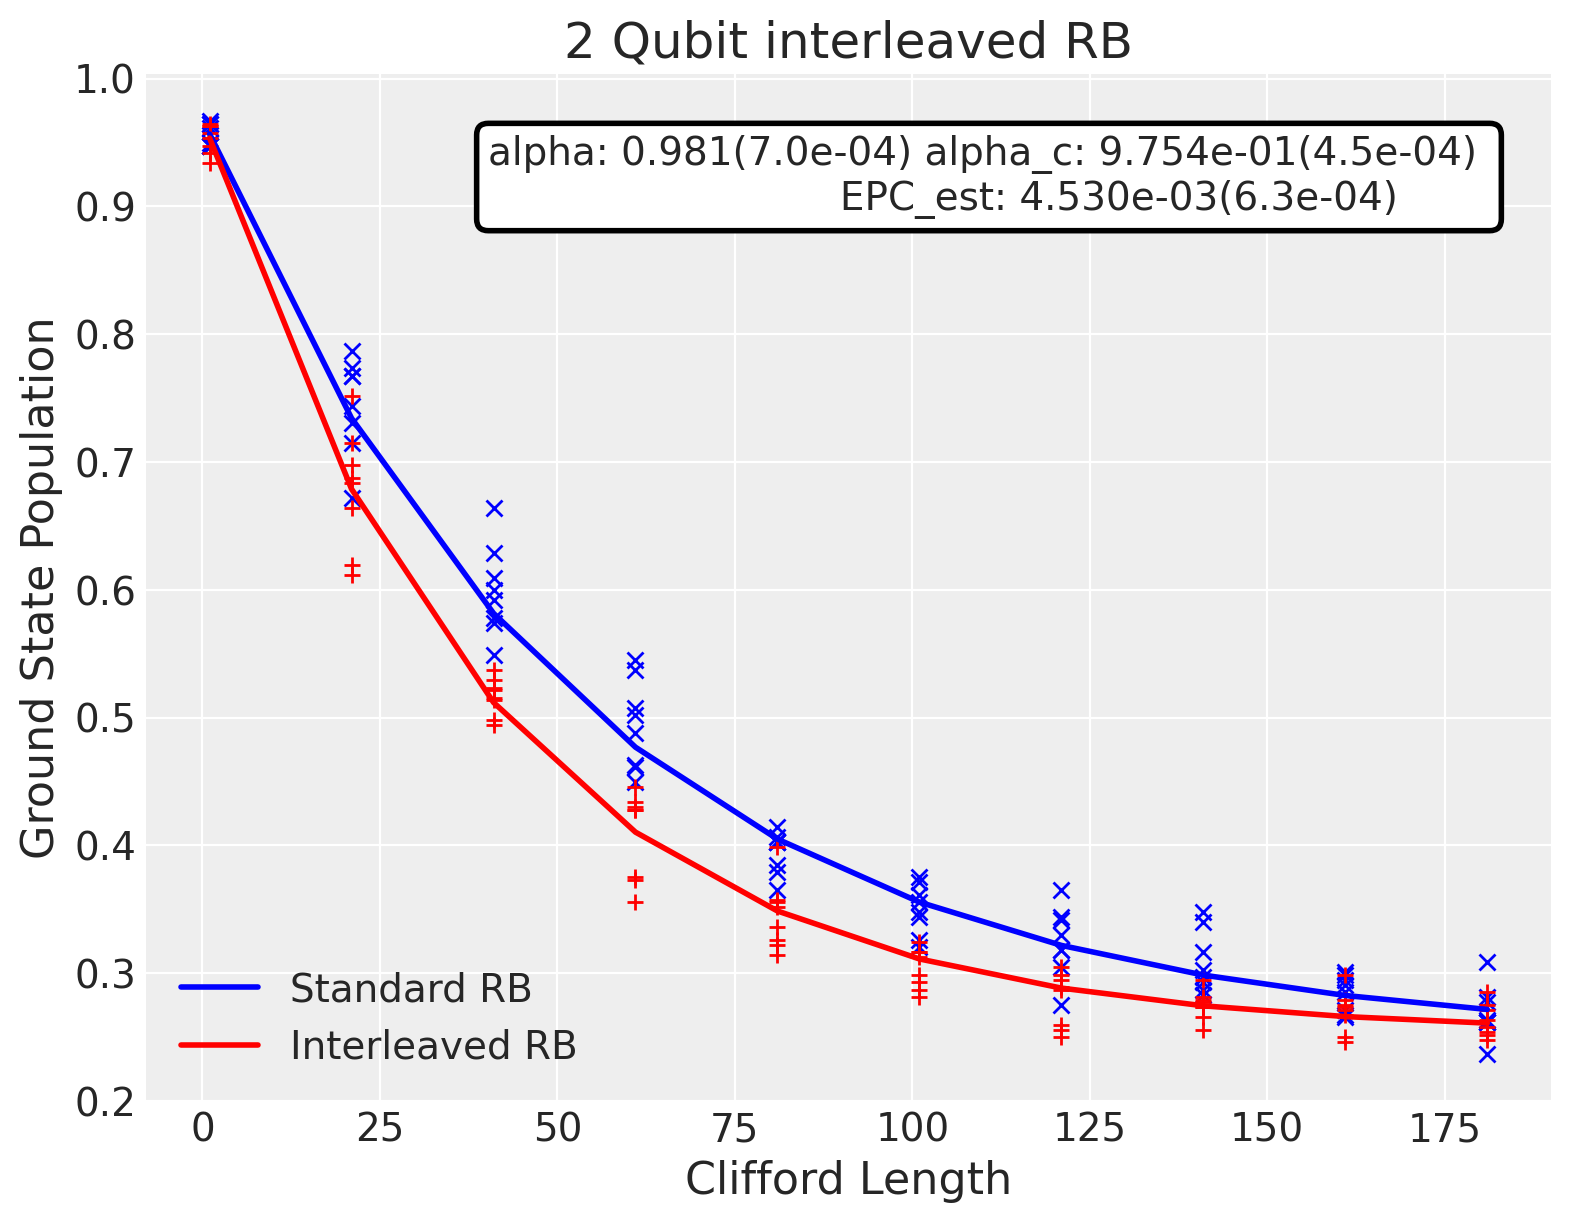

In [37]:
#when retrieving hardware jobs, this shows only half the data 
    #Plot the joint RB data WIP
if RB_process != "2-3_Q RB" and retrieve_list == []:
    import matplotlib.pyplot as plt # seems we need to reimport for replot WIP
   
    nb_subfig = 1
    if RB_process == "3_Q RB":
        nb_subfig = 2    
    plt.figure(figsize=(15, 6))

    for i in range(nb_subfig):
        ax = plt.subplot(1, 2, i+1)
        pattern_ind = i

        # Plot the essence by calling plot_rb_data
        joint_rb_fit.plot_rb_data(pattern_ind, ax=ax, add_label=True, show_plt=False)

        # Add title and label
        ax.set_title('%d Qubit interleaved RB'%(len(rb_opts['rb_pattern'][i])), fontsize=18)

    plt.show()

##  Bayesian inference

## Original

In [38]:
m_gates, _, alpha_ref, alpha_lower, alpha_upper, mu_AB, cov_AB, sigma_theta =\
    obtain_priors_and_data_from_fitter(rbfit = original_rb_fit, printout = True) 

priors:
alpha_ref 0.98134991746802
alpha_lower 0.9322824215946189 alpha_upper 1.0
A,B [0.72248264 0.24764864] 
cov A,B [6.41753309e-05 5.80345287e-05]
sigma_theta 0.004


In [39]:
Y1 = get_count_data(original_result_list)

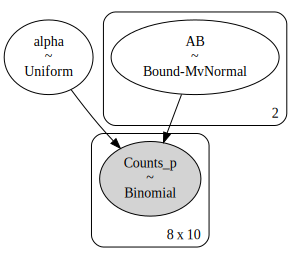

In [40]:
original_model = get_bayesian_model(model_type="pooled",Y=Y1,shots=shots,m_gates=m_gates,mu_AB=mu_AB,cov_AB=cov_AB)
pm.model_to_graphviz(original_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [AB, alpha]


Sampling 4 chains for 10_000 tune and 2_000 draw iterations (40_000 + 8_000 draws total) took 91 seconds.


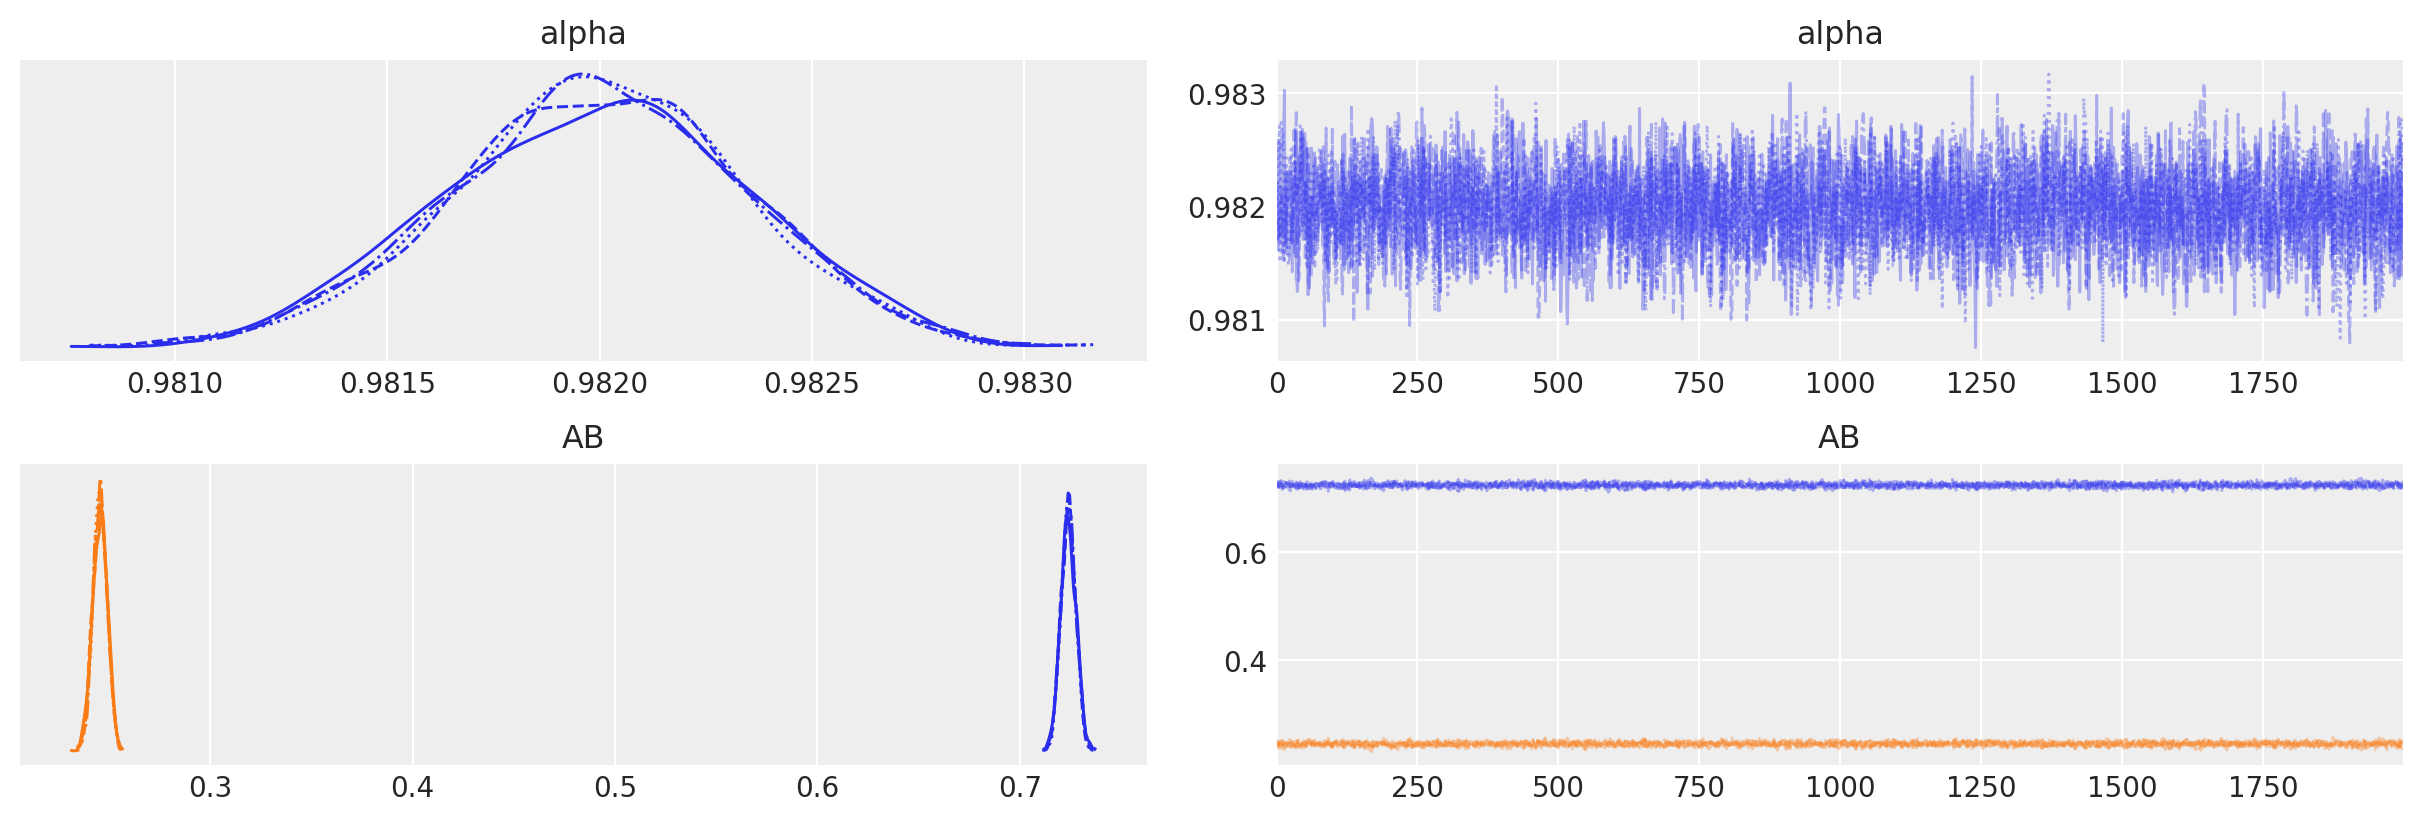

In [41]:
trace_o = get_trace(original_model)

In [42]:
azo_summary = get_summary(original_model, trace_o)
azo_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.9820,0.0003,0.9813,0.9826,0.0000,0.0,3623.3765,4337.4483,1.0006
AB[0],0.7241,0.0037,0.7171,0.7308,0.0001,0.0,3869.5049,4265.3627,1.0009
AB[1],0.2455,0.0036,0.2393,0.2526,0.0001,0.0,3422.1814,3898.0603,1.0022


In [43]:
alpha_original_p = azo_summary['mean']['alpha']
alpha_original_p_err = azo_summary['sd']['alpha']

## Interleaved

In [44]:
m_gates, _, alpha_ref, alpha_lower, alpha_upper, mu_AB, cov_AB, sigma_theta =\
    obtain_priors_and_data_from_fitter(rbfit = interleaved_rb_fit, printout = True)

priors:
alpha_ref 0.9754223007882685
alpha_lower 0.9266511857488551 alpha_upper 1.0
A,B [0.71817617 0.25292241] 
cov A,B [1.69476076e-05 7.65854114e-06]
sigma_theta 0.004


In [45]:
Y2 = get_count_data(interleaved_result_list)

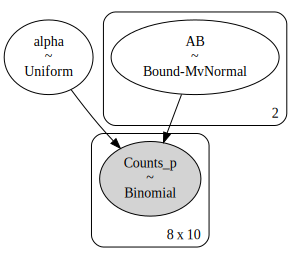

In [46]:
interleaved_model = get_bayesian_model(model_type="pooled",Y=Y2,shots=shots,m_gates=m_gates,mu_AB=mu_AB,cov_AB=cov_AB)
pm.model_to_graphviz(interleaved_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [AB, alpha]


Sampling 4 chains for 10_000 tune and 2_000 draw iterations (40_000 + 8_000 draws total) took 76 seconds.


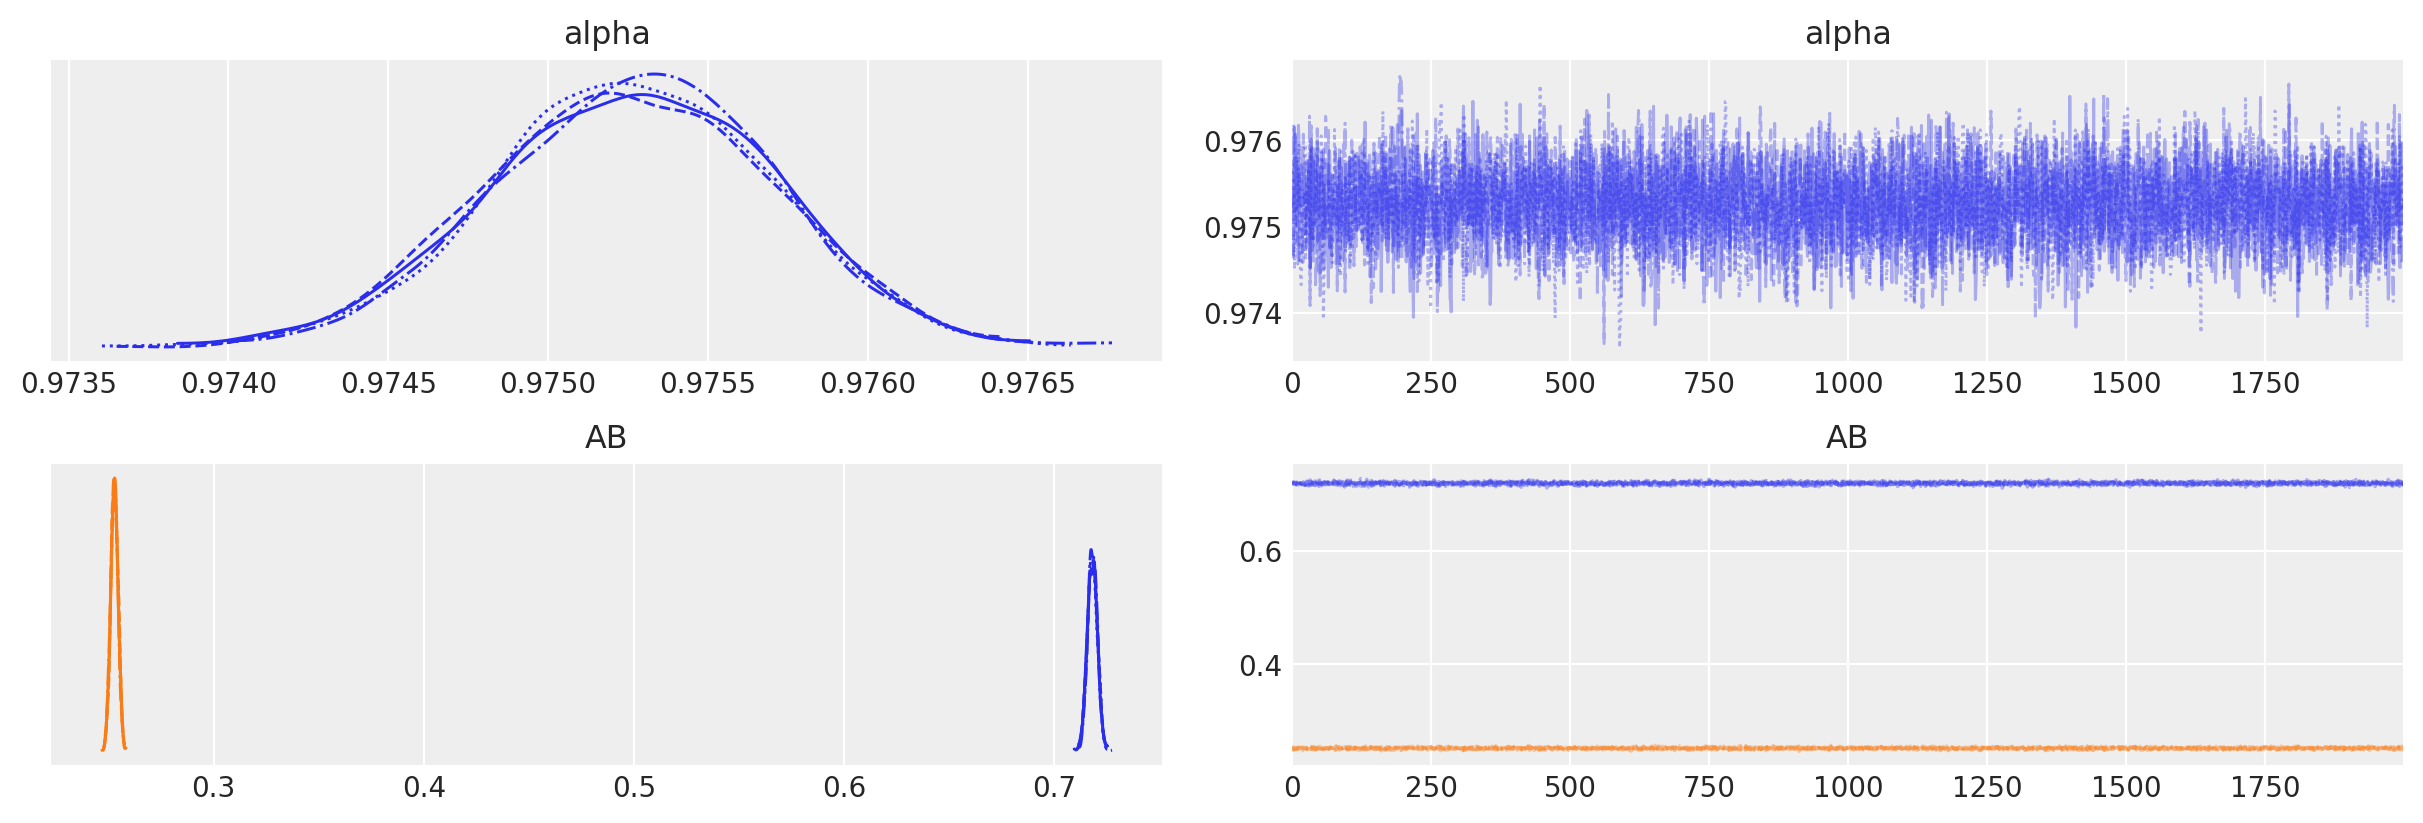

In [47]:
trace_i = get_trace(interleaved_model)

In [48]:
azi_summary = get_summary(interleaved_model, trace_i)
azi_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.9753,0.0004,0.9745,0.9761,0.0,0.0,5106.8605,5181.9886,1.0005
AB[0],0.7182,0.0023,0.7137,0.7224,0.0,0.0,5801.9192,5278.3077,1.0005
AB[1],0.2528,0.0017,0.2494,0.2559,0.0,0.0,4530.6920,5113.2751,1.0004


In [49]:
alpha_c_p = azi_summary['mean']['alpha']
alpha_c_p_err = azi_summary['sd']['alpha']

###  Accelerated RB

model: [equation 5 in this paper](https://arxiv.org/abs/1404.5275) 

In [50]:
m_gates, _, alpha_ref, alpha_lower, alpha_upper, mu_AB, cov_AB, sigma_theta =\
    obtain_priors_and_data_from_fitter(rbfit = original_rb_fit, printout = True)

priors:
alpha_ref 0.98134991746802
alpha_lower 0.9322824215946189 alpha_upper 1.0
A,B [0.72248264 0.24764864] 
cov A,B [6.41753309e-05 5.80345287e-05]
sigma_theta 0.004


In [51]:
Y = np.vstack((Y1,Y2))

In [52]:
# WIP this to do in the model funtion?
RvsI = np.vstack((np.ones_like(Y1),np.zeros_like(Y2)))

In [53]:
# WIP this to do in the model funtion?
IvsR = np.vstack((np.zeros_like(Y1),np.ones_like(Y2)))

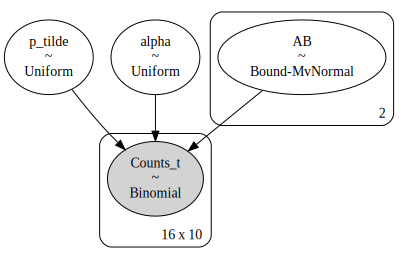

In [54]:
tilde = get_bayesian_model("tilde",Y=Y,shots=shots,m_gates=m_gates,mu_AB=mu_AB,cov_AB=cov_AB,RvsI=RvsI,IvsR=IvsR)
pm.model_to_graphviz(tilde)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_tilde, AB, alpha]


Sampling 4 chains for 10_000 tune and 2_000 draw iterations (40_000 + 8_000 draws total) took 87 seconds.


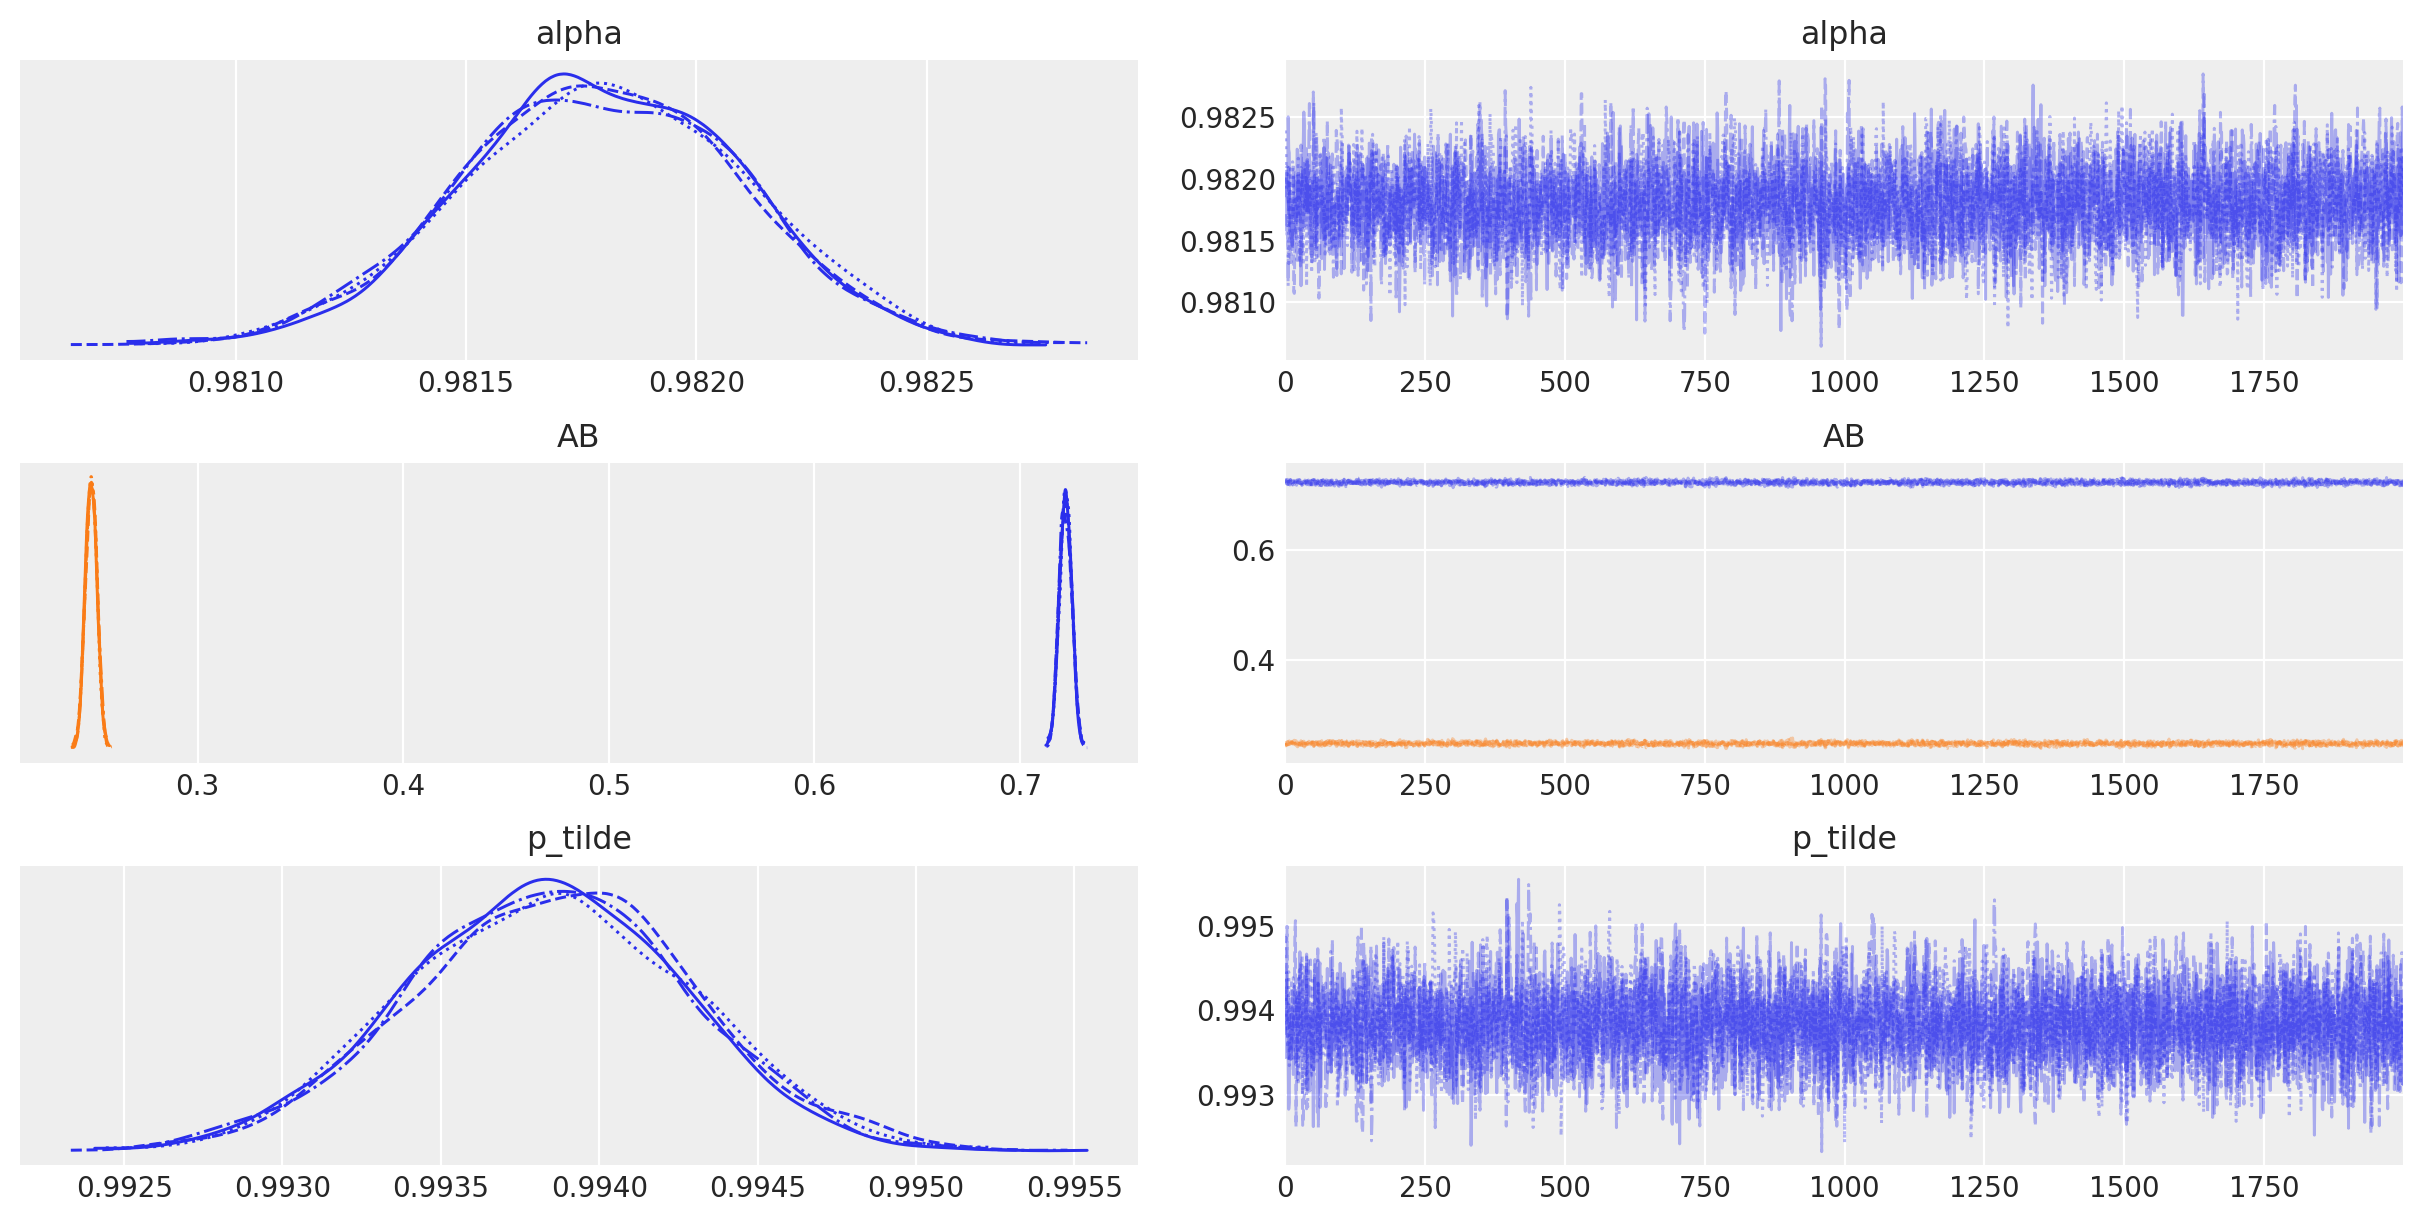

In [55]:
trace_t = get_trace(tilde)

In [56]:
azt_summary = get_summary(tilde, trace_t)
azt_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.9818,0.0003,0.9812,0.9824,0.0,0.0,4663.0530,5123.7519,1.0007
AB[0],0.7222,0.0030,0.7165,0.7277,0.0,0.0,3967.0758,5030.5254,1.0006
AB[1],0.2482,0.0028,0.2430,0.2533,0.0,0.0,3583.1512,4505.2296,1.0007
p_tilde,0.9938,0.0004,0.9930,0.9947,0.0,0.0,5469.3045,4700.2129,1.0010


# Final comparison

#### How to get the EPC_est error calculation from $\alpha$ and $\alpha^{C}$
from: rb.InterleavedRBFitter:
epc_est_err = ((nrb - 1) / nrb) * (alpha_c / alpha) \
                * (np.sqrt(alpha_err_sq + alpha_c_err_sq))

In [57]:
# WIP WIP WIP
# added option of pooled 2-3_Q R
epc_calib = 6.06E-3 # enter here the read calibration error of the device, 0.0 if None WIP
epc_est_p = 3*(1 - alpha_c_p/alpha_original_p)/4
epc_est_p_err = 3*(alpha_c_p/alpha_original_p)/4*(np.sqrt(alpha_original_p_err**2 + alpha_c_p_err**2))
if RB_process == "2-3_Q RB":
    epc_est_fitter, epc_est_fitter_err = epc_fitter_when_mixed_2Q_3Q_RB(m_gates,
                                                        Y1,Y2,shots,check_plot=False)
else:
    epc_est_fitter = joint_rb_fit.fit_int[0]["epc_est"]
    epc_est_fitter_err = joint_rb_fit.fit_int[0]["epc_est_err"]

epc_est_a =3/4*(1 - azt_summary['mean']['p_tilde'])
epc_est_a_err = 3/4* (azt_summary['sd']['p_tilde'])
print("       fitter 2xpooled  tilde calibration")
print("EPC   {0:.5f} {1:.5f}  {2:.5f}  {3:.5f} ".format(epc_est_fitter, epc_est_p, epc_est_a, epc_calib))
print("ERROR {0:.5f} {1:.5f}  {2:.5f}    --- ".format(epc_est_fitter_err, epc_est_p_err, epc_est_a_err))

       fitter 2xpooled  tilde calibration
EPC   0.00453 0.00512  0.00465  0.00606 
ERROR 0.00063 0.00037  0.00030    --- 


In [58]:
# for refering the interleaved gate in the title of the graphs
intl_g=str(interleaved_gates[0][0][0:2])+str(rb_pattern[0][0:2]) 

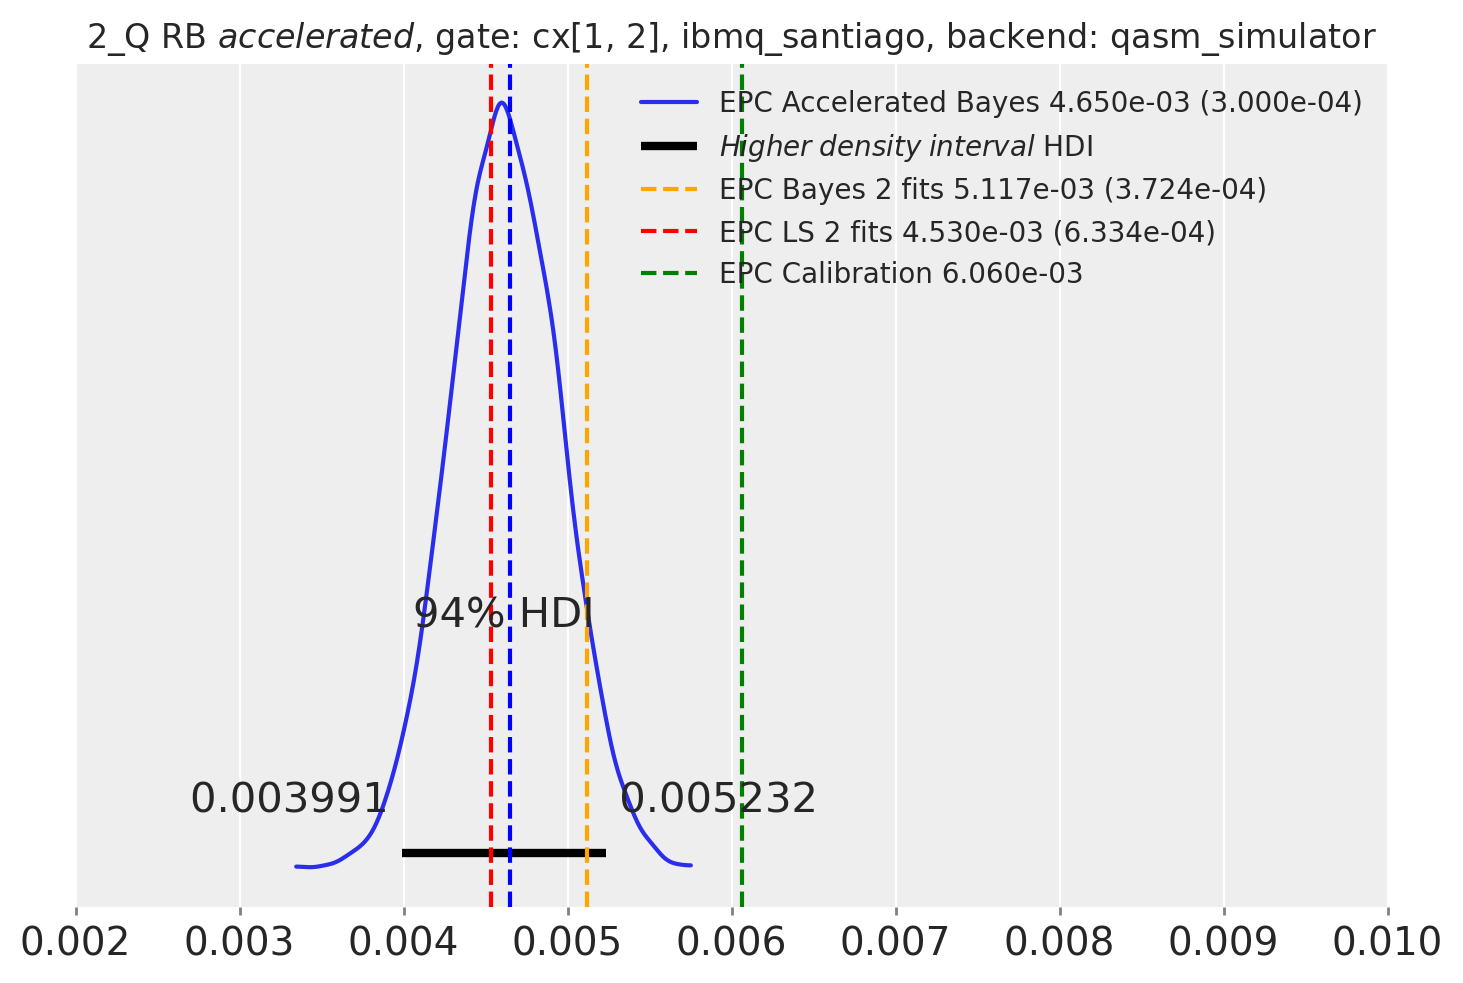

In [64]:
import matplotlib.pyplot as plt # seems we need to reimport for replot WIP

with tilde:
        ax = az.plot_posterior(trace_t,  var_names=['p_tilde'], round_to=4, point_estimate=None, 
                          transform =  alpha_to_EPC)
        ax.set_xlim(0.002, 0.010)
        plt.axvline(x=epc_est_p,color='orange',ls="--")
        plt.axvline(x=epc_est_fitter,color='red',ls="--")
        if epc_calib > 0.0:
            plt.axvline(x=epc_calib,color='green',ls="--")
        plt.axvline(x=epc_est_a,color='blue',ls="--")
        plt.title(RB_process +' $accelerated$, gate: ' + intl_g\
                  +", "+hardware+', backend: '+backend.name(),
               fontsize=12)
        Bayes_legend ="EPC Accelerated Bayes {0:1.3e} ({1:1.3e})".format(epc_est_a, epc_est_a_err)
        Bayes2_legend ="EPC Bayes 2 fits {0:1.3e} ({1:1.3e})".format(epc_est_p, epc_est_p_err)
        Fitter_legend ="EPC LS 2 fits {0:1.3e} ({1:1.3e})".format(epc_est_fitter, epc_est_fitter_err)                                                        
        Cal_legend ="EPC Calibration {0:1.3e}".format(epc_calib)
        if epc_calib > 0.0:
            plt.legend((Bayes_legend, "$Higher\; density\; interval$ HDI",Bayes2_legend,
                        Fitter_legend,Cal_legend), fontsize=10 )
        else: 
            plt.legend((Bayes_legend, "$Higher\; density\; interval$ HDI",Bayes2_legend,
                        Fitter_legend), fontsize=10 )

In [60]:
import matplotlib.pyplot as plt # seems we need to reimport for replot WIP

Text(0.5, 1.0, '2_Q RB $accelerated$, gate: cx[1, 2], ibmq_santiago, backend: qasm_simulator')

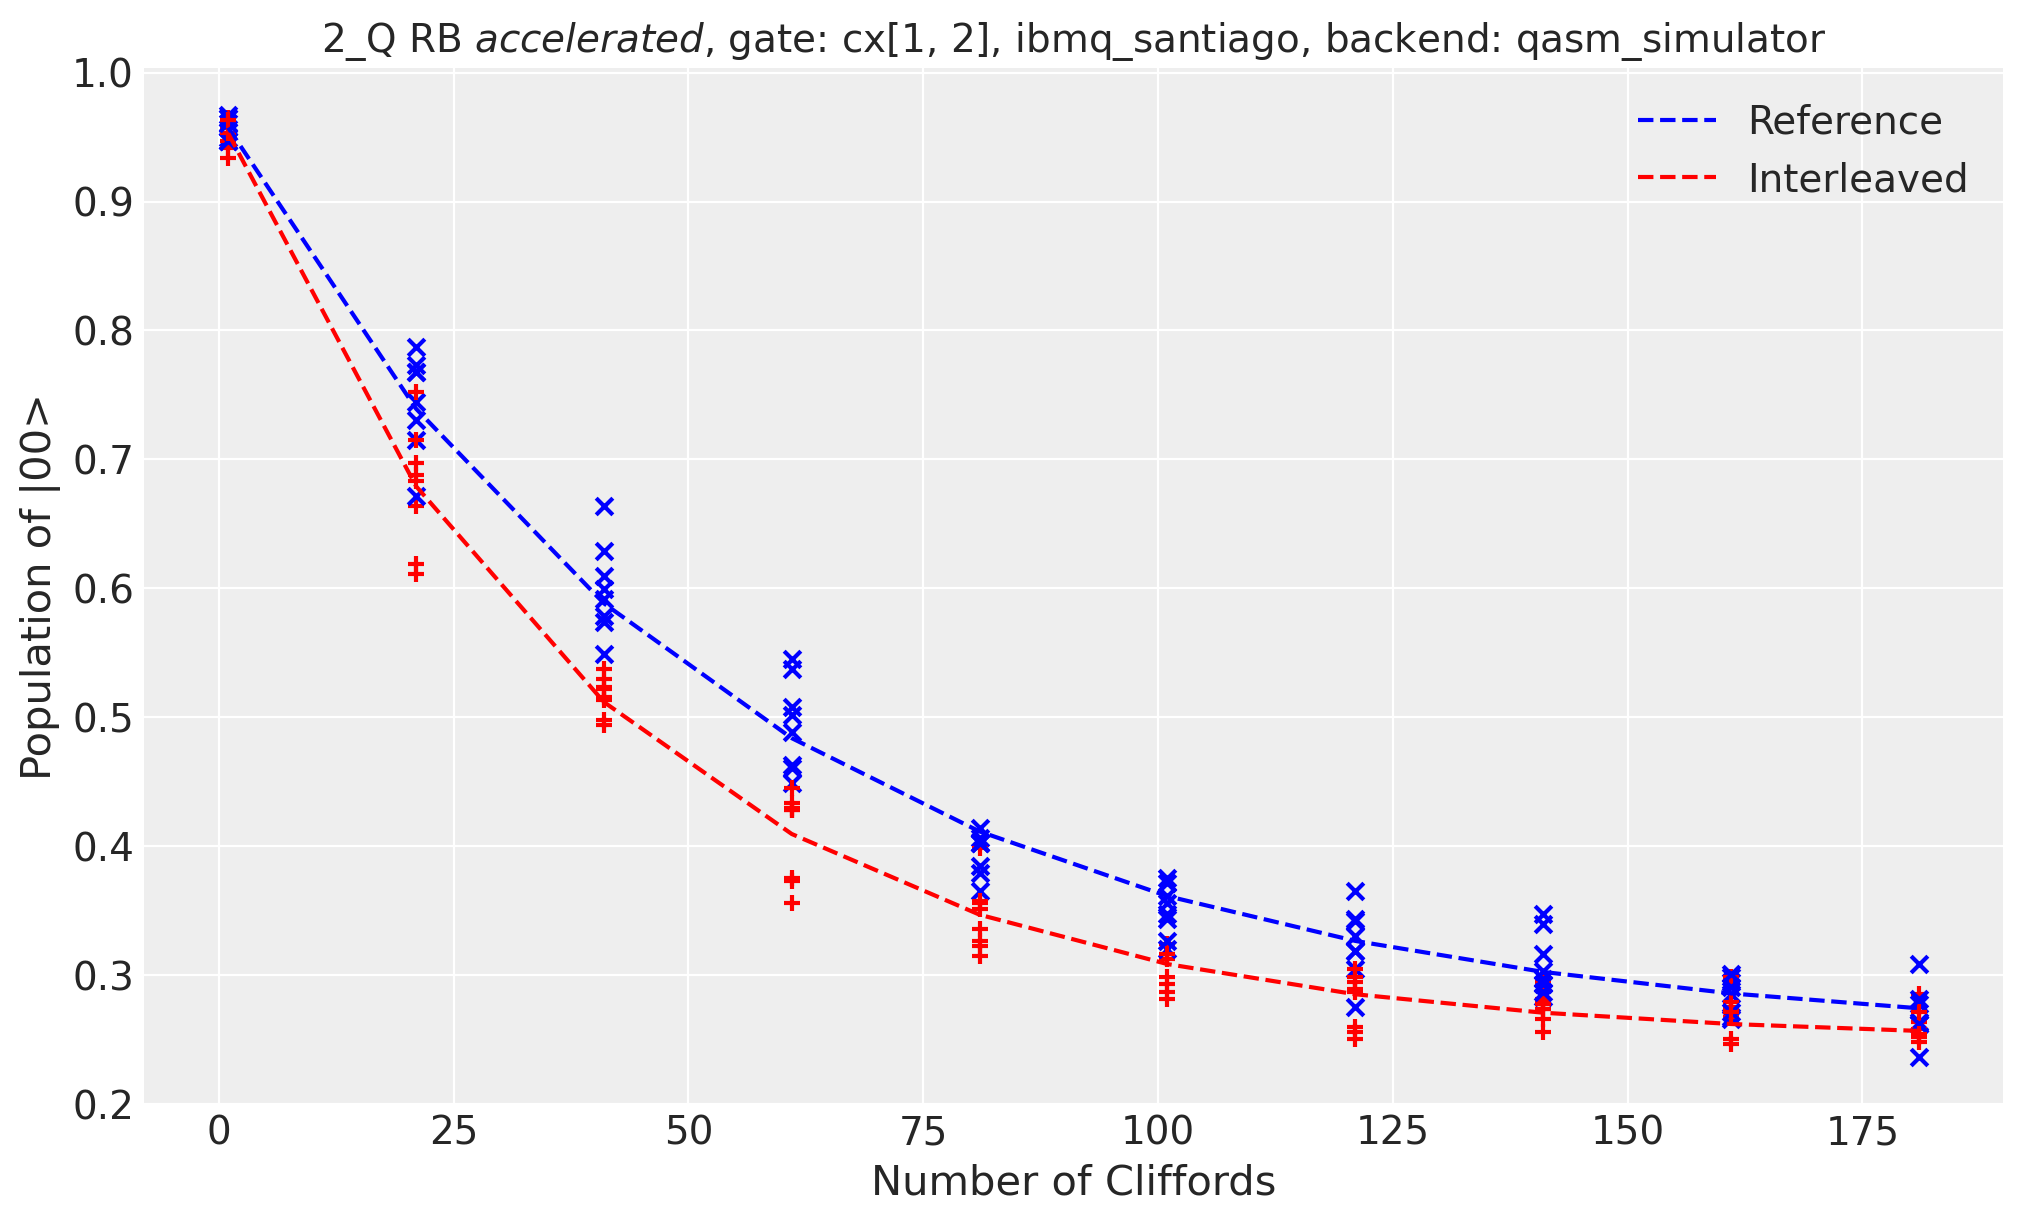

In [61]:
#fig, plt = plt.subplots(1, 1, sharex=True, figsize=(10, 6))
fig, plt = plt.subplots(1, 1, sharex=True, figsize=(10, 6))

plt.set_ylabel("Population of |00>")
plt.set_xlabel("Number of Cliffords")

for i_seed in range(nseeds):
    plt.scatter(m_gates, Y1[i_seed,:]/shots, label = "data", marker="x",color="b")
    plt.scatter(m_gates, Y2[i_seed,:]/shots, label = "data", marker="+",color="r")
plt.plot(m_gates,azt_summary['mean']['AB[0]']*azt_summary['mean']['alpha']**m_gates+\
          azt_summary['mean']['AB[1]'],'--',color="b")
plt.plot(m_gates,azt_summary['mean']['AB[0]']*(azt_summary['mean']['alpha']*azt_summary['mean']['p_tilde'])**\
          m_gates+azt_summary['mean']['AB[1]'],'--',color="r")

plt.legend(("Reference",
             "Interleaved"))

plt.set_title(RB_process +' $accelerated$, gate: ' + intl_g\
                  +", "+hardware+', backend: '+backend.name(),
               fontsize=14)

In [62]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

In [63]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Apr 18 2021

Python implementation: CPython
Python version       : 3.8.1
IPython version      : 7.12.0

arviz  : 0.11.2
IPython: 7.12.0
pymc3  : 3.11.1
numpy  : 1.18.1
qiskit : 0.23.0

Watermark: 2.2.0

